# Automatic Ticket Classification

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
## Mounting Goodle Drive to pull the Raw Data
import pathlib
import os
from google.colab import drive
drive.mount('/content/gdrive')
base_dir = pathlib.Path('gdrive/My Drive/AutomaticTicketClassification/RawData.json')
#os.chdir(str(base_dir))
# Opening JSON file 
f = open(str(base_dir))
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

Mounted at /content/gdrive


## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

# Calling data shape
df.shape

(78313, 22)

In [4]:
# Making all columns of the dataframe visible.
pd.set_option('display.max_columns', None)

In [5]:
# Checking data head
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
# Pulling Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#print the column names
cols = df.columns.to_list()
print("Columns names:\n",cols)

Columns names:
 ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [8]:
# Checking null value counts for each column.
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [9]:
#Assign new column names
cols_new = [re.sub('source.','',col[1:]) for col in cols]
print("New column names:\n",cols_new, "\n")

# Fitting new column names
df.columns = cols_new
df.head()

New column names:
 ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'] 



,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A




```
# Findings
- Column "Complaint_what_happened" is primary reference point, it got few blank rows in it which we remove.
- Updated column names as "." could have created issues in further steps of data analysis.
- Few more columns can be dropped which don't hold much value to data.
```



In [10]:
# Checking Null rows in "complaints_what_happened" column.
df.complaint_what_happened.isnull().sum()

0

In [11]:
# Number of rows with blank complaints
print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))


No. of rows with blank complaints:  57241


In [12]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r"^\s*$",np.NaN,regex=True)
print("No. of rows with nan in complaints column: ", df.complaint_what_happened.isnull().sum())

No. of rows with nan in complaints column:  57241


In [13]:
# Number of rows with blank complaints after replacing with NaN
print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

No. of rows with blank complaints:  0


In [14]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

print("The Latest shape of dataframe:",df.shape)

The Latest shape of dataframe: (21072, 22)


In [15]:
# Checking the data head again
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    # Text to lower case
    text1 = text.lower()
    
    # Removing any leading and trailing spaces
    text2 = text1.strip()
    
    # Removing text within square brackets
    text3 = re.sub(r"[\[].*?[\]]","",text2).strip()
    
    # Removing punctuations
    text4 = re.sub(r"[^\w\s]","",text3).strip()
    
    # Removing words containing numbers
    text5 = re.sub("\S*\d\S*","",text4).strip()   
    
    return text5

In [17]:
df['complaints_cleaned'] = df.complaint_what_happened.apply(text_preprocess)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


In [18]:
# Importing libraries for text processing steps.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
df_clean = df.complaints_cleaned.to_frame()
df_clean.columns = ["complaints"]
df_clean.head()

,complaints
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [20]:
# Importing "swifter" to speed up lemmatization using mutithread processing.

!pip install swifter
import swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16299 sha256=d78004426f2e2c67faca1c70439781828c827d4a539f247c7138e586397bb0ae
  Stored in directory: /root/.cache/pip/wheels/6c/bd/3e/2d6afc9bc36c9975f8e4215a270bbac6580c4361ebd6bb2323
Successfully built swifter


In [21]:
#Write your function to Lemmatize the texts

stopwords = stopwords.words('english')
wordnet_lem = WordNetLemmatizer()

def lemmatizer(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    proc_token = []
    # Using nltk pos tagger which may not capture the context like Spacy's POS tagger. However, it should be good enough for use here.
    for word,pos in pos_tag(tokens):
        try:
            proc_token.append(wordnet_lem.lemmatize(word,pos = pos[0].lower()))
        except:
            proc_token.append(wordnet_lem.lemmatize(word))
    lemmatized_text = ' '.join(proc_token)
    return lemmatized_text

In [22]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_what_happened","complaints_cleaned"]]
#df_clean.columns = ["raw_complaints","cleaned_complaints"]

# Apply lemmatization and store the output in a separate column
df_clean["lemmatized_complaints"] = df_clean["complaints_cleaned"].swifter.apply(lemmatizer)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

<ipython-input-22-61110f61c6ba>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


It seems the words of interest for Topic Modelling are nouns & proper nouns. Words with other POS tags are doesn't seem valuable to us.
Hence, the code below creates a new column which includes only words with POS tags as nouns.

In [24]:
#Write your function to extract the POS tags (Using Spacy)

nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

pos_tags = []  # List to store POS tags of each lemmatized complaint
nouns = []     # List to store only the nouns from the complaint

for complaint in tqdm(df_clean.lemmatized_complaints):
    pos = ''
    noun = ''
    proc_complaint = nlp(complaint)
    for tok in proc_complaint:
        pos += tok.pos_ + ' '
        if tok.pos_ in str(('NOUN', 'PROPN')) :
            noun += (tok.lemma_.lower()) + ' '
    pos_tags.append(pos.strip())
    nouns.append(noun.strip())

100%|██████████| 21072/21072 [15:40<00:00, 22.40it/s]


In [25]:
df_clean['pos_tags_lemmatized'] = pd.Series(pos_tags, index=df_clean.index)
df_clean['complaints_nouns_only'] = pd.Series(nouns, index=df_clean.index)

#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

<ipython-input-25-7afb67b73a8c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-7afb67b73a8c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
#The clean dataframe should now contain the raw complaint, cleaned_complaints, lemmatized complaints with respective POS tags, 
#Also, the complaints after removing words with non-noun (NOUN, PROPN) POS tags.
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name xxxx xxxx chase bank cardmember s...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,VERB PROPN PROPN NOUN VERB NOUN NOUN NOUN NOUN...,xxxx xxxx card agent upgrade anniversary date ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book xxxx xxxx ticket offer ticket reward card...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN NOUN ADJ P...,grand son check deposit chase account fund cha...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [27]:
df_clean.complaint_what_happened.str.len().sort_values(ascending=False)

436      31611
11241    31385
14251    29948
2308     29239
1130     25757
         ...  
16450       21
8825        21
1619        20
5799        19
8697        19
Name: complaint_what_happened, Length: 21072, dtype: int64

Text(0.5, 0, 'Character length ranges')

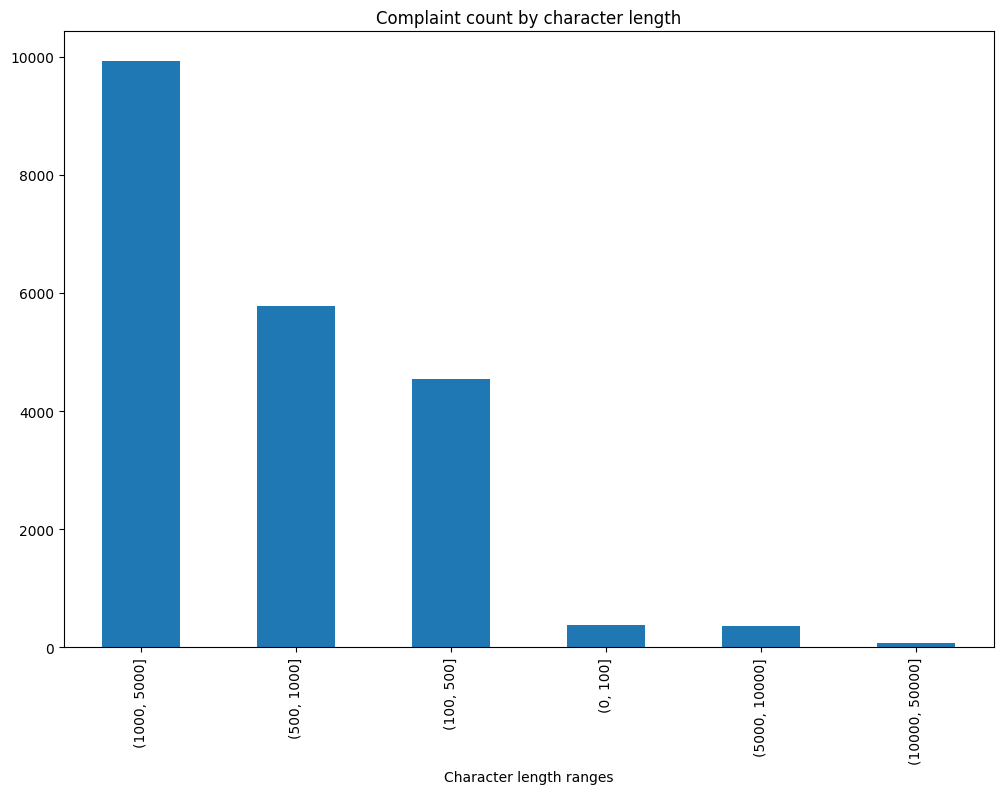

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean.complaint_what_happened.str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

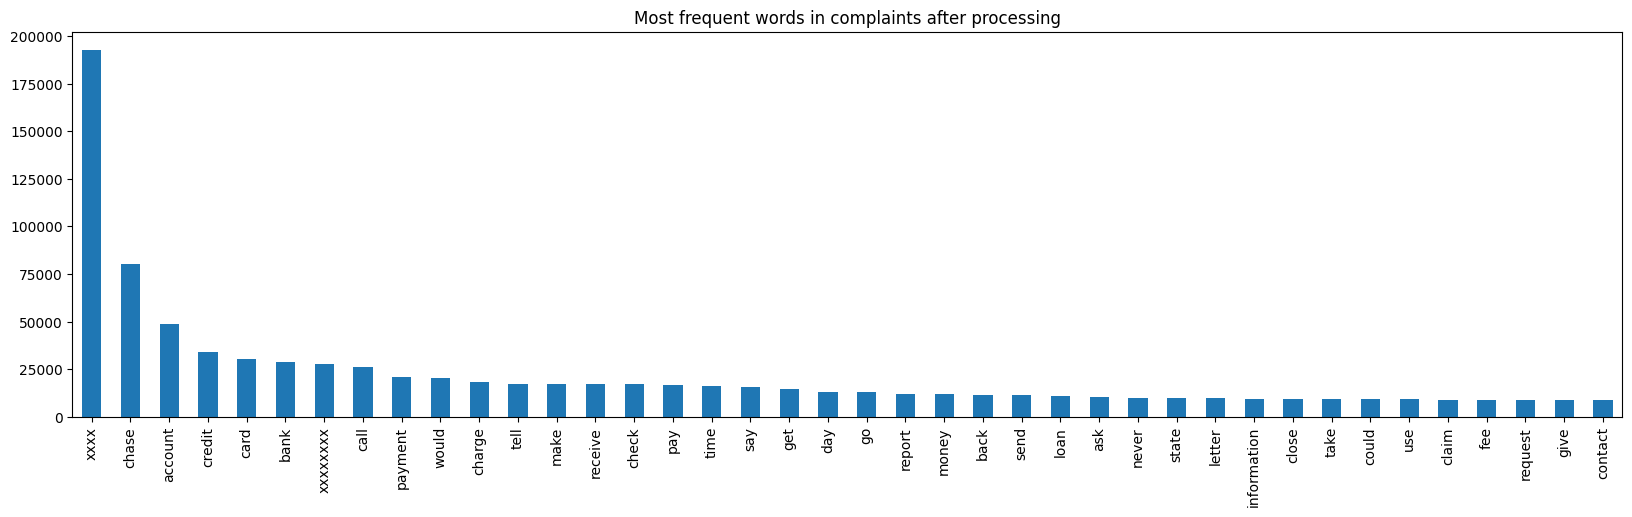

In [29]:
# Most frequent words in the processed (lemmatized) complaints
most_freq_lem=[] # List to extract most frequent words

for complaint in df_clean.lemmatized_complaints:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

In [30]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


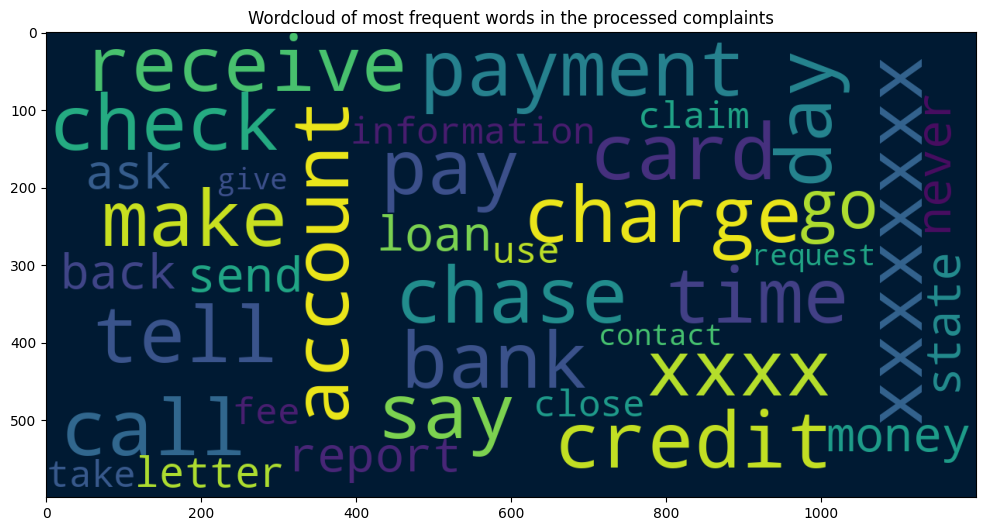

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis', max_words = 50, contour_width = 3, max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_words = pd.DataFrame(most_freq_lem)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent words in the processed complaints")
plt.show()

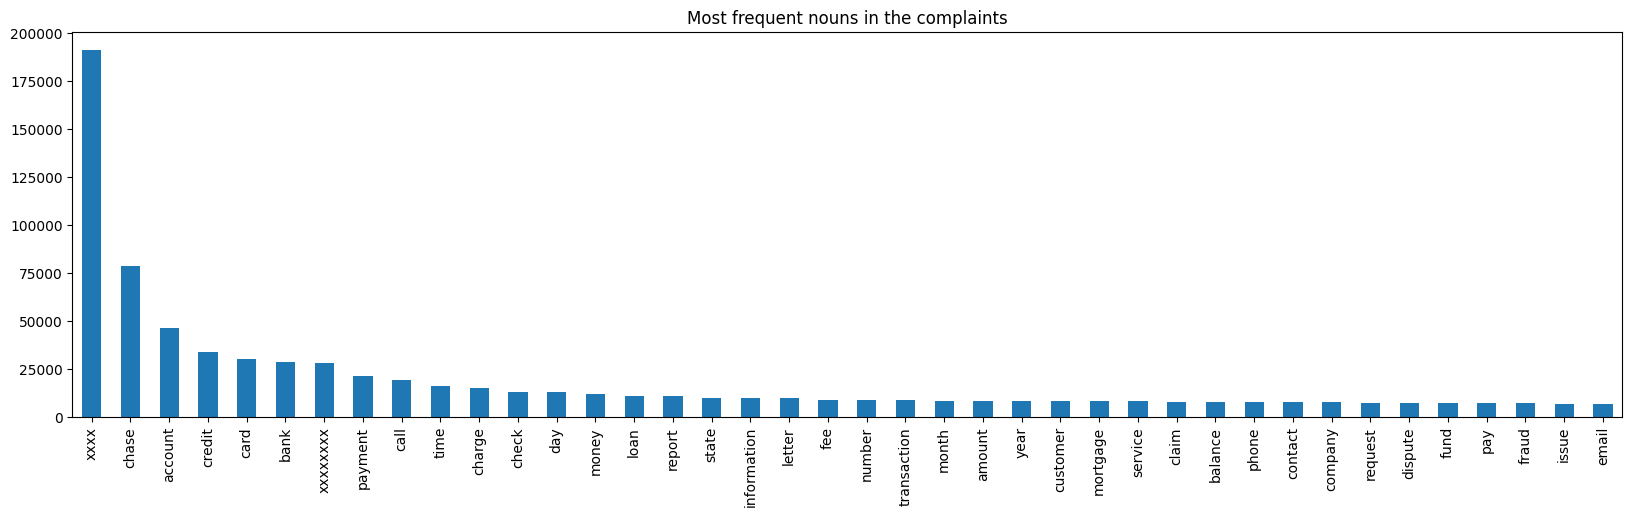

In [32]:
# Most frequent nouns in the processed complaints
most_freq_nouns=[] # List to extract most frequent nouns

for complaint in df_clean.complaints_nouns_only:
    for word in complaint.split(' '):
        most_freq_nouns.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent nouns in the complaints")
plt.show()

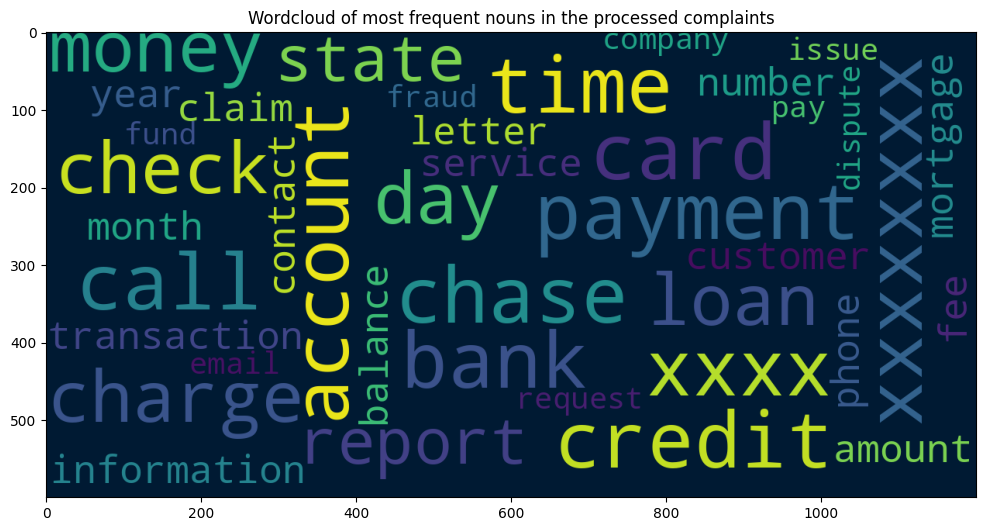

In [33]:
#Using a word cloud find the top 40 nouns by frequency among all the articles after processing the text

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis', max_words = 50, contour_width = 3, max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_noun_words = pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_noun_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent nouns in the processed complaints")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [34]:
# Importing libs
from nltk.util import ngrams 
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

In [35]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word') 
word_vect = vectorizer.fit_transform(df_clean['complaints_nouns_only']) 
freqs = sum(word_vect).toarray()[0]

unigram_df = pd.DataFrame(freqs, index=vectorizer.get_feature_names_out(), columns=['frequency']) 

In [36]:
#Print the top 30 words in the unigram by frequency
print("Top 30 words in the unigram by frequency:")
unigram_df.sort_values(by="frequency", ascending = False).head(30)

Top 30 words in the unigram by frequency:


,frequency
xxxx,190985
chase,78353
account,46313
credit,33926
card,30419
bank,28609
xxxxxxxx,27900
payment,21162
call,19286
time,16068


<Figure size 2000x500 with 0 Axes>

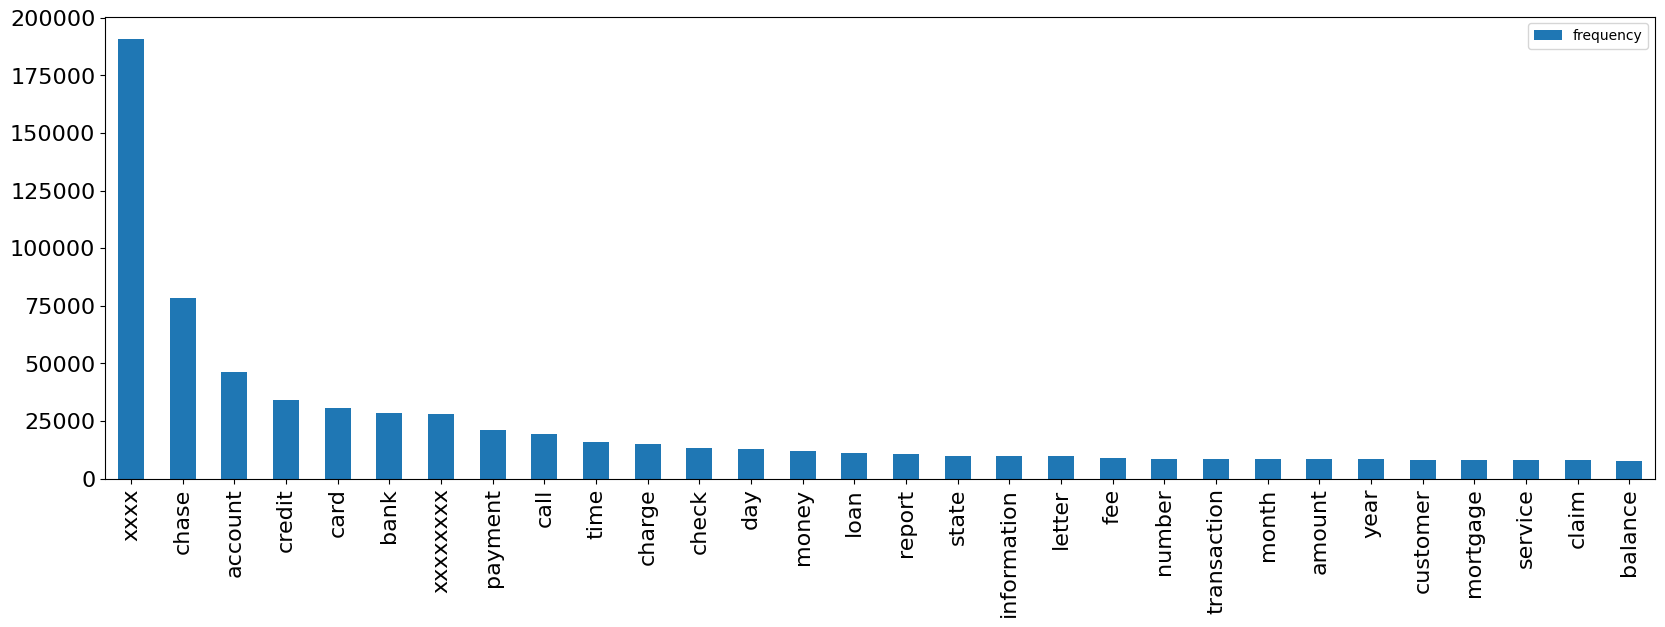

In [37]:
plt.figure(figsize=(20, 5))
unigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [38]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), analyzer='word') 
word_vector_bigram = vectorizer_bigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_bigram = sum(word_vector_bigram).toarray()[0]

bigram_df = pd.DataFrame(freqs_bigram, index=vectorizer_bigram.get_feature_names_out(), columns=['frequency'])


Top 30 bigrams by frequency:
                   frequency
xxxx xxxx              87610
chase bank             12839
credit card            12828
xxxx chase              5879
call chase              4226
credit report           3994
xxxxxxxx xxxx           3785
chase xxxx              3721
check account           3624
xxxx xxxxxxxx           3295
chase credit            3223
account xxxx            3178
account chase           3172
customer service        3077
xxxx account            2729
xxxxxxxx xxxxxxxx       2660
xxxx credit             2599
jp morgan               2488
morgan chase            2475
bank account            2419
chase account           2231
bank xxxx               2078
call xxxx               1993
number xxxx             1967
xxxx payment            1896
debit card              1894
contact chase           1862
xxxxxxxx chase          1844
card xxxx               1799
credit score            1709


<Figure size 2000x500 with 0 Axes>

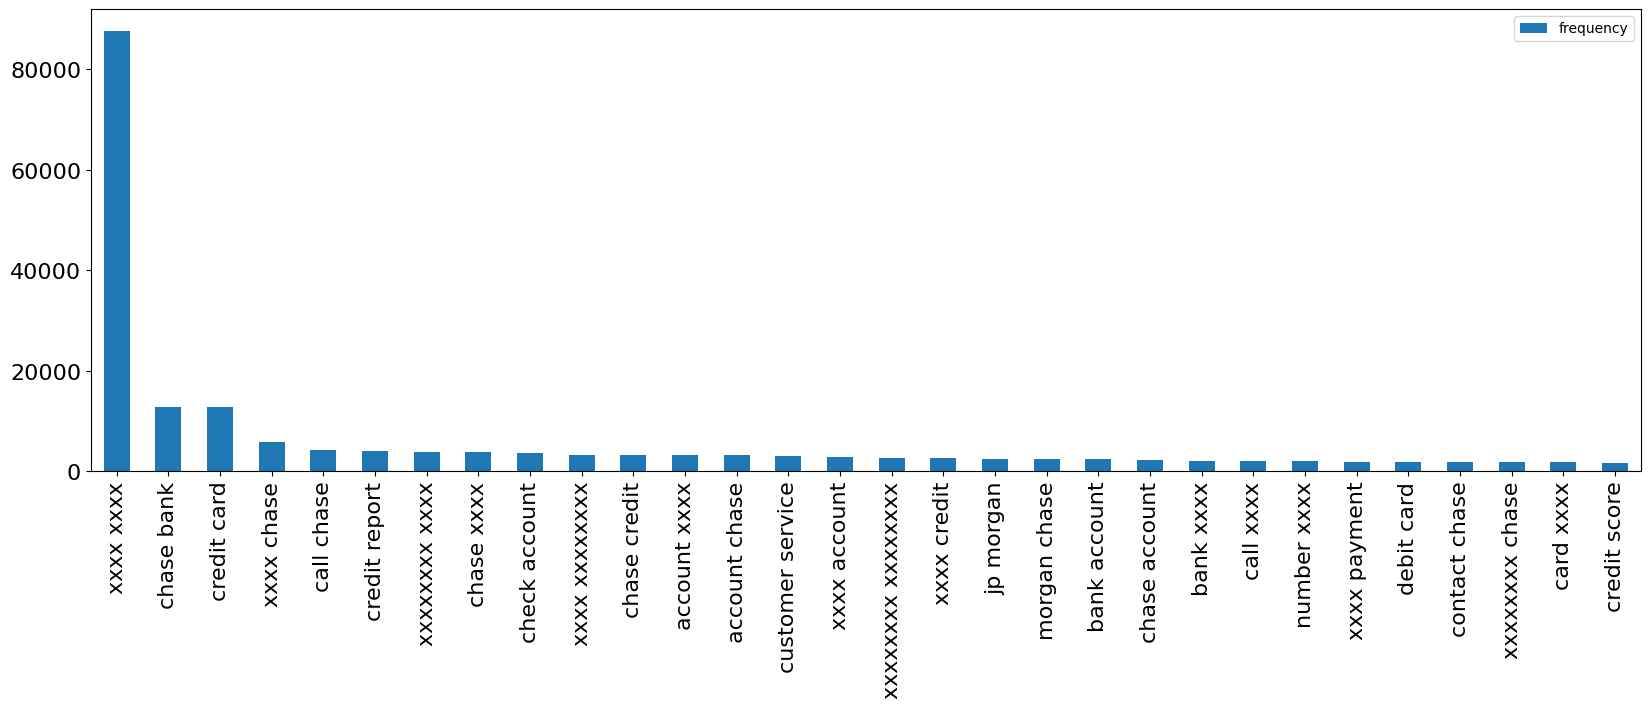

In [39]:
#Print thelemmatized_complaints 10 words in the bigram frequency
print("Top 30 bigrams by frequency:")
print(bigram_df.sort_values(by="frequency", ascending = False).head(30))

plt.figure(figsize=(20, 5))
bigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [40]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_trigram = CountVectorizer(ngram_range=(3,3), analyzer='word') 
word_vector_trigram = vectorizer_trigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_trigram = sum(word_vector_trigram).toarray()[0]

trigram_df = pd.DataFrame(freqs_trigram, index=vectorizer_trigram.get_feature_names_out(), columns=['frequency'])

Top 30 trigrams by frequency:
                            frequency
xxxx xxxx xxxx                  43575
xxxx xxxx chase                  2672
chase credit card                2290
jp morgan chase                  2060
xxxxxxxx xxxx xxxx               1896
xxxx xxxx xxxxxxxx               1548
chase xxxx xxxx                  1461
account xxxx xxxx                1246
chase bank xxxx                  1225
xxxx credit card                 1203
xxxx xxxx account                1125
xxxx xxxxxxxx xxxx               1122
bank xxxx xxxx                   1105
credit card account              1025
xxxx xxxx credit                  989
xxxx chase bank                   976
name xxxx xxxx                    972
credit card company               971
credit card chase                 853
call xxxx xxxx                    769
account chase bank                768
xxxx xxxx payment                 761
card xxxx xxxx                    724
payment xxxx xxxx                 723
xxxxxxxx xxxxxxxx xx

<Figure size 2000x500 with 0 Axes>

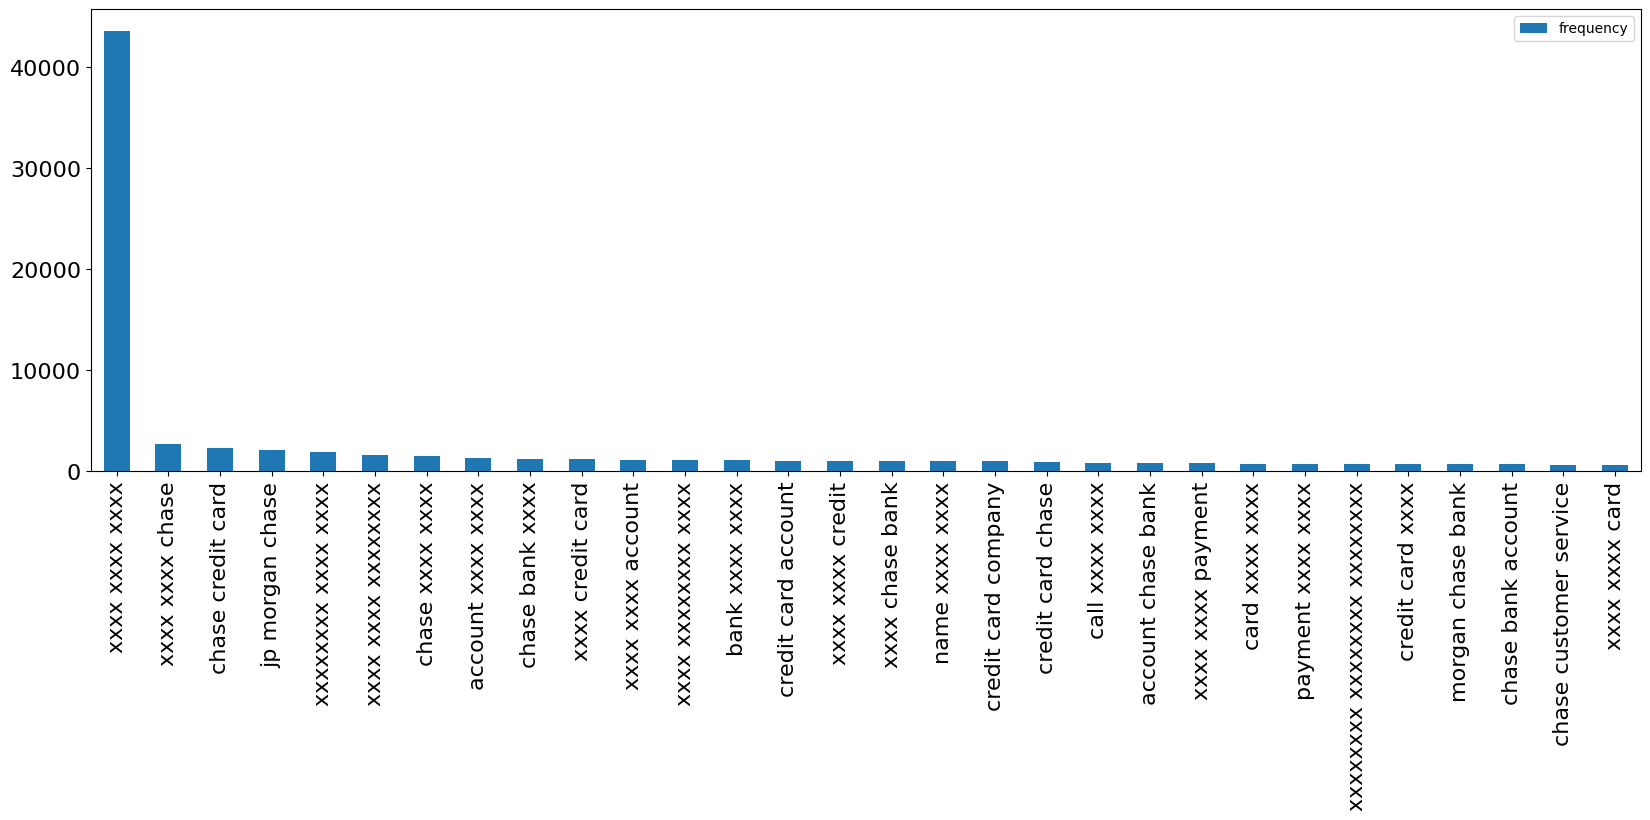

In [41]:
#Print the top 30 words in the trigram frequency
print("Top 30 trigrams by frequency:")
print(trigram_df.sort_values(by="frequency", ascending = False).head(30))

plt.figure(figsize=(20, 5))
trigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [42]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name xxxx xxxx chase bank cardmember s...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,VERB PROPN PROPN NOUN VERB NOUN NOUN NOUN NOUN...,xxxx xxxx card agent upgrade anniversary date ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book xxxx xxxx ticket offer ticket reward card...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN NOUN ADJ P...,grand son check deposit chase account fund cha...


In [43]:
# Removing masked customer names and other masked data signified by 'xxxx', since they are of no use to us.
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xxxx','')
df_clean['lemmatized_complaints'] = df_clean['lemmatized_complaints'].str.replace('xxxx','')
df_clean['complaints_nouns_only'] = df_clean['complaints_nouns_only'].str.replace('xxxx','')

<ipython-input-43-0e4d2227662f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-0e4d2227662f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-0e4d2227662f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name chase bank cardmember service w...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB PROPN PROPN NOUN VERB NOUN NOUN NOUN NOUN...,card agent upgrade anniversary date agent in...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...,try book ticket come across offer apply towa...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book ticket offer ticket reward card informa...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN NOUN ADJ P...,grand son check deposit chase account fund cha...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    max_features=5000, # Keeping max_features to 5000 to keep within memory limits.
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [46]:
#Write your code here to create the Document Term Matrix (tfidf) by transforming the complaints column present in df_clean.

tfidf = tfidf_vectorizer.fit_transform(df_clean['complaints_nouns_only'])
features = tfidf_vectorizer.get_feature_names_out()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

ability  abuse  accept  acceptance  access  access account  access bank  \
0      0.0    0.0     0.0         0.0     0.0             0.0          0.0   
1      0.0    0.0     0.0         0.0     0.0             0.0          0.0   
2      0.0    0.0     0.0         0.0     0.0             0.0          0.0   
3      0.0    0.0     0.0         0.0     0.0             0.0          0.0   
4      0.0    0.0     0.0         0.0     0.0             0.0          0.0   

   access chase  access credit  access fund  access information  access money  \
0           0.0            0.0          0.0                 0.0           0.0   
1           0.0            0.0          0.0                 0.0           0.0   
2           0.0            0.0          0.0                 0.0           0.0   
3           0.0            0.0          0.0                 0.0           0.0   
4           0.0            0.0          0.0                 0.0           0.0   

   accident  accommodation  accord  accord chase  accordance   account  \
0       0.0            0.0     0.0           0.0         0.0  0.052746   
1       0.0            0.0     0.0           0.0         0.0  0.056909   
2       0.0            0.0     0.0           0.0         0.0  0.000000   
3       0.0            0.0     0.0           0.0         0.0  0.096163   
4       0.0            0.0     0.0           0.0         0.0  0.085978   

   account access  account account  account account account  \
0             0.0              0.0                      0.0   
1             0.0              0.0                      0.0   
2             0.0              0.0                      0.0   
3             0.0              0.0                      0.0   
4             0.0              0.0                      0.0   

   account account balance  account account chase  account account number  \
0                      0.0                    0.0                     0.0   
1                      0.0                    0.0                     0.0   
2                      0.0                    0.0                     0.0   
3                      0.0                    0.0                     0.0   
4                      0.0                    0.0                     0.0   

   account activity  account address  account advise  account agreement  \
0               0.0              0.0             0.0                0.0   
1               0.0              0.0             0.0                0.0   
2               0.0              0.0             0.0                0.0   
3               0.0              0.0             0.0                0.0   
4               0.0              0.0             0.0                0.0   

   account amount  account ask  account atm  account attempt  \
0             0.0     0.000000          0.0              0.0   
1             0.0     0.000000          0.0              0.0   
2             0.0     0.000000          0.0              0.0   
3             0.0     0.127354          0.0              0.0   
4             0.0     0.000000          0.0              0.0   

   account authorization  account balance  account balance account  \
0                    0.0              0.0                      0.0   
1                    0.0              0.0                      0.0   
2                    0.0              0.0                      0.0   
3                    0.0              0.0                      0.0   
4                    0.0              0.0                      0.0   

   account bank  account bank account  account banker  account banking  \
0           0.0                   0.0             0.0              0.0   
1           0.0                   0.0             0.0              0.0   
2           0.0                   0.0             0.0              0.0   
3           0.0                   0.0             0.0              0.0   
4           0.0                   0.0             0.0              0.0   

   account base  account bill  account block  account bonu

In [47]:
# Checking the shape
tfidf_df.shape

(21072, 5000)

In [48]:
len(tfidf_vectorizer.get_feature_names_out())

5000

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [49]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [50]:
#Load your nmf_model with the n_components 

#Initial test with num_topics = 15
num_topics = 15 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [51]:
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

In [52]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,call,chase,phone,number,letter,email,information,time,customer,service,state,day,address,request,call chase
Topic 2,card,credit,credit card,chase credit,chase credit card,chase,card chase,chase card,score,card account,card credit,limit,credit card chase,use,credit score
Topic 3,mortgage,home,property,chase,modification,foreclosure,chase mortgage,sale,year,house,escrow,mortgage payment,tax,insurance,bankruptcy
Topic 4,inquiry,inquiry credit,inquiry credit report,credit report,credit,jpmcb,credit inquiry,card inquiry,jpmcb card,report inquiry,inquiry inquiry,inquiry chase,application,credit report inquiry,report
Topic 5,payment,payment payment,month,payment chase,chase payment,pay,amount,chase,day,payment credit,time,payment month,auto,payment account,account payment
Topic 6,charge,dispute,merchant,dispute charge,chase,company,refund,charge chase,purchase,amount,charge account,item,charge charge,service,chase dispute
Topic 7,fee,overdraft,overdraft fee,charge,charge fee,fee charge,transaction,fee account,charge overdraft,fee fee,fee chase,pay,time,charge overdraft fee,year
Topic 8,account,account chase,chase account,account account,chase,check account,bank account,reason,access,transfer,balance,card account,branch,business,account number
Topic 9,bank,chase bank,chase,bank account,money,bank chase,chase bank account,account chase bank,bank chase bank,bank bank,bank credit,wire,complaint,call chase bank,chase bank credit
Topic 10,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,complaint,account jp,account jp morgan,morgan chase credit,bank jp,bank jp morgan,morgan chase account,foreclosure


- Many topics are visible and finding correlations between each topic is also difficult.
- It may be better to try smaller number of topics.

## Running code again but with 10 topics

In [55]:
#Load your nmf_model with the n_components 

# Trying 10 topics
num_topics = 10 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,call,chase,claim,number,phone,transaction,email,fraud,day,time,information,money,customer,letter,department
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card chase,score,chase card,limit,card credit,card account,credit card chase,credit score,balance
Topic 3,loan,mortgage,modification,home,chase,property,year,foreclosure,rate,morgan,loan modification,house,sale,document,jp
Topic 4,report,inquiry,credit,credit report,inquiry credit,inquiry credit report,report credit,bureau,credit bureau,jpmcb,debt,reporting,information,company,credit reporting
Topic 5,payment,payment payment,month,balance,payment chase,pay,chase,statement,chase payment,amount,interest,auto,time,day,credit
Topic 6,charge,dispute,merchant,chase,dispute charge,company,refund,amount,charge chase,purchase,item,charge account,fraud,chase dispute,service
Topic 7,fee,overdraft,balance,charge,overdraft fee,interest,transaction,charge fee,pay,fee charge,transfer,rate,fee account,balance transfer,statement
Topic 8,account,account chase,chase account,account account,chase,check account,bank account,reason,access,transfer,balance,account credit,card account,account number,money account
Topic 9,bank,chase bank,chase,money,bank account,bank chase,morgan,chase bank account,morgan chase,jp,jp morgan,jp morgan chase,account chase bank,morgan chase bank,wire
Topic 10,check,deposit,fund,check account,money,cash,day,branch,deposit check,atm,bank,chase,business,check deposit,account


- Decreasing topics count to get good coherence in the topics.

## Running the code again with 5 topics

In [56]:
#Load your nmf_model with the n_components 

# Trying 5 topics
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,deposit,chase bank,fund,transaction,call,branch,day,check account,claim,account chase
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,call,company,merchant,service,card chase,time
Topic 3,loan,mortgage,chase,home,modification,property,morgan,foreclosure,document,year,letter,jp,jp morgan,morgan chase,sale
Topic 4,report,credit,inquiry,credit report,inquiry credit,inquiry credit report,bureau,account,report credit,credit bureau,debt,score,jpmcb,reporting,information
Topic 5,payment,balance,fee,interest,month,payment payment,pay,statement,payment chase,amount,chase,chase payment,bill,time,account


- Results look nice as topic seems have coherance.

In [57]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping_num = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [58]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping_num.get(x.idxmax()) if x.idxmax() in topic_mapping_num.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.021248,0.003901,0.018765,0.013128,0.003528,0
1,0.005095,0.013486,0.004983,0.001598,0.001149,1
2,0.000000,0.022723,0.001905,0.037152,0.000000,3
3,0.018295,0.021567,0.016797,0.061368,0.000000,3
4,0.063054,0.000000,0.001552,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.104108,0.000000,3
6,0.053460,0.002704,0.008727,0.000000,0.011020,0
7,0.002344,0.006711,0.043061,0.000000,0.052651,4
8,0.039819,0.023596,0.020718,0.004901,0.002211,0
9,0.000000,0.046711,0.000000,0.063885,0.000000,3


In [59]:
# Checking the frequency of each identified topic
W['max_topic'].value_counts()

1    6129
0    6048
2    3875
4    2538
3    2482
Name: max_topic, dtype: int64

In [60]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] =W['max_topic'].apply(lambda x:int(x))

<ipython-input-60-e13c6cff133b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
df_clean.tail()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only,Topic
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,NOUN NOUN NOUN ADV NOUN VERB ADJ NOUN VERB ADJ...,chase card customer decade solicitation credit...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...,wednesday call chas visa credit card provid...,PROPN PROPN PROPN PROPN PROPN PROPN PROPN NOUN...,wednesday call chas visa credit card provid...,1
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...,familiar pay understand great risk provide co...,ADJ NOUN VERB VERB ADJ NOUN VERB NOUN VERB ADJ...,risk consumer chase bank app chase year trust...,0
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,ADJ NOUN NOUN PRON VERB NOUN NOUN NOUN NOUN NO...,credit yrs chase credit card chase freedom pr...,4
21071,Roughly 10+ years ago I closed out my accounts...,roughly years ago i closed out my accounts wi...,roughly year ago close account jp morgan chase...,ADV NOUN ADV ADJ NOUN PROPN PROPN PROPN PROPN ...,year account jp morgan chase bank order line ...,4


In [62]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   complaints_cleaned       21072 non-null  object
 2   lemmatized_complaints    21072 non-null  object
 3   pos_tags_lemmatized      21072 non-null  object
 4   complaints_nouns_only    21072 non-null  object
 5   Topic                    21072 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 987.9+ KB


In [63]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample = df_clean.groupby('Topic').head(5)

#df_clean_sample.sort_values('Topic')
df_clean_sample.sort_values(by='Topic')

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name chase bank cardmember service w...,0
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN NOUN ADJ P...,grand son check deposit chase account fund cha...,0
10,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and,mishandle account chase auto,NOUN NOUN NOUN NOUN NOUN,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,VERB PROPN PROPN PROPN PROPN NOUN NOUN NOUN PR...,jp morgan chase restrict account debit card tu...,0
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on i made a payment to an online retailer u...,make payment online retailer use chase quick ...,PROPN VERB NOUN ADJ NOUN VERB NOUN ADJ NOUN PR...,payment retailer chase pay chase website sca...,0
22,My roommate was stealing my Chase debit card a...,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,NOUN ADJ NOUN NOUN NOUN NOUN NOUN NOUN VERB NO...,roommate chase debit card driver license prete...,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,i am a senior citizen that has been scammed by...,senior citizen scammed several company pay t...,ADJ NOUN VERB ADJ NOUN PROPN PROPN VERB NOUN N...,citizen company time share company credit ca...,1
16,"XXXX XXXX a sofa, love seat, table and chairs ...",a sofa love seat table and chairs and was ne...,sofa love seat table chair never deliver deb...,PROPN PROPN PROPN PROPN NOUN NOUN NOUN ADV VER...,sofa love seat table chair debit card charge...,1
14,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase amazon card decline cater order place br...,PROPN PROPN PROPN PROPN NOUN NOUN NOUN NOUN NO...,chase amazon card decline cater order place br...,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB PROPN PROPN NOUN VERB NOUN NOUN NOUN NOUN...,card agent upgrade anniversary date agent in...,1


In [64]:
# Checking whether each complaint has an assigned topic or not; and whether the count for each topic matches that from our Document-Topic matrix
df_clean.Topic.value_counts()

1    6129
0    6048
2    3875
4    2538
3    2482
Name: Topic, dtype: int64

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [65]:
#Create the dictionary of Topic names and Topics

Topic_names =   {
                0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"
                }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-65-1eec3f6f8e87>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
df_clean.Topic.value_counts()

Credit Card/Prepaid Card    6129
Bank account services       6048
Mortgages/loans             3875
Others                      2538
Theft/Dispute reporting     2482
Name: Topic, dtype: int64

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [67]:
#Creating the dictionary again of Topic names and Topics

topic_labels = {
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic labels
df_clean['Topic'] = df_clean['Topic'].map(topic_labels)

<ipython-input-67-db0428824cb6>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
df_clean

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name chase bank cardmember service w...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB PROPN PROPN NOUN VERB NOUN NOUN NOUN NOUN...,card agent upgrade anniversary date agent in...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...,try book ticket come across offer apply towa...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book ticket offer ticket reward card informa...,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN NOUN ADJ P...,grand son check deposit chase account fund cha...,0
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,NOUN NOUN NOUN ADV NOUN VERB ADJ NOUN VERB ADJ...,chase card customer decade solicitation credit...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...,wednesday call chas visa credit card provid...,PROPN PROPN PROPN PROPN PROPN PROPN PROPN NOUN...,wednesday call chas visa credit card provid...,1
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...,familiar pay understand great risk provide co...,ADJ NOUN VERB VERB ADJ NOUN VERB NOUN VERB ADJ...,risk consumer chase bank app chase year trust...,0
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,ADJ NOUN NOUN PRON VERB NOUN NOUN NOUN NOUN NO...,credit yrs chase credit card chase freedom pr...,4


In [69]:
#Keeping the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [70]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [71]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",3
4,my grand son give me check for {$1600.00} i de...,0


In [72]:
training_data.Topic.value_counts()

1    6129
0    6048
2    3875
4    2538
3    2482
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [73]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data.complaint_what_happened)

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


In [74]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 883)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Write your code here to build any 3 models and evaluate them using the required metrics

## Model Training & Evaluation

### Preparing data to train models

In [75]:
# Creating a dataframe of the tf-idf vector for use in model training.
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names_out(),index=training_data.index)
word_vect_df.head()

,00,00 account,00 chase,00 xx,00 xx xx,00 xxxx,00 xxxx xxxx,10,10 days,100,100 00,1000,1000 00,12,15,18,19,20,200,200 00,2000,2000 00,2015,2016,2017,2018,2019,2020,24,30,30 days,50,500,500 00,60,90,ability,able,absolutely,accept,accepted,access,according,account,account chase,account chase bank,account closed,account number,account xx,account xx xx,account xxxx,account xxxx xxxx,accounts,act,action,actions,activity,actually,add,added,addition,additional,address,advised,agencies,agency,agent,ago,agreed,agreement,alert,allow,allowed,amazon,amounts,annual,answer,app,apparently,appears,application,applied,apply,approval,approved,approximately,ask,asked,asking,assist,assistance,assured,atm,attached,attempt,attempted,attempts,attorney,authorization,authorize,authorized,auto,available,avoid,aware,away,bad,balance,bank,bank account,bank chase,bank xx,bank xx xx,bank xxxx,bank xxxx xxxx,banker,banking,bankruptcy,banks,based,began,beginning,behalf,believe,best,better,billing,bills,bonus,branch,branch manager,branch xxxx,bureau,bureaus,business,business days,buy,ca,called,called chase,called xxxx,called xxxx xxxx,calling,calls,came,cancel,cancelled,car,card,card account,card chase,card company,card xx,card xx xx,card xxxx,cards,care,case,cash,cause,caused,causing,cfpb,change,changed,charge,charged,charges,charging,chase,chase account,chase bank,chase bank xxxx,chase branch,chase card,chase chase,chase checking,chase closed,chase credit,chase credit card,chase customer,chase customer service,chase did,chase freedom,chase mortgage,chase representative,chase said,chase sent,chase told,chase xx,chase xx xx,chase xxxx,chase xxxx xxxx,check,check xxxx,checked,checking,checking account,checks,claim,claimed,claiming,claims,clear,cleared,clearly,close,close account,closed,closed account,closing,code,collect,collection,come,communication,companies,company,complaint,complaint chase,complaints,complete,completed,completely,concern,confirm,confirmation,confirmed,consumer,consumers,contact,contact chase,contacted,contacted chase,contacted xxxx,contacting,continue,continued,contract,conversation,copies,copy,correct,correspondence,cost,couple,course,court,cover,covid,credit,credit account,credit bureaus,credit card,credit card account,credit card chase,credit card company,credit cards,credit report,credit reporting,credit reports,credit score,credited,current,currently,customer,customer service,customers,date,date xx,date xx xx,dated,dated xx,dated xx xx,dates,day,days,days later,deal,debit,debit card,debt,decided,decision,declined,denied,department,deposit,deposited,deposits,dept,despite,details,did,did receive,didn,didnt,different,direct,directly,discovered,dispute,disputed,document,documentation,documents,does,doing,dollars,don,dont,early,email,emailed,emails,employee,employees,end,ended,ending,ending xxxx,entire,error,escrow,evidence,executive,executive office,explain,explained,explanation,extra,extremely,fact,failed,fair,false,family,far,fault,fax,federal,fee,feel,fees,file,filed,filing,final,finally,finance,financial,fine,fix,fixed,follow,followed,following,forced,foreclosure,form,forward,fraud,fraud department,fraudulent,free,freedom,friday,funds,future,gave,getting,given,giving,going,gone,good,got,government,happen,happened,hard,having,hear,heard,held,help,high,higher,history,hold,holder,holding,home,honor,hour,hours,house,husband,id,idea,identity,identity theft,illegal,im,immediately,included,including,income,incorrect,indicated,info,inform,information,informed,initial,initially,initiated,inquiries,inquiry,instead,institution,insurance,investigate,investigation,involved,issue,issued,issues,item,items,job,jp,jp morgan,jp morgan chase,jpmorgan,jpmorgan chase,just,kept,kind,knew,know,knowledge,lack,large,late,late fees,late payment,later,law,leave,left,legal,lender,let,let know,letter,letter chase,letters,life,like,limit,line,listed,little,live,loan,loan modification,loan xxxx,loans,local,located,location,long,longer,look,looked,looking,loss,lost,

In [76]:
word_vect_df.shape

(21072, 883)

- We got 883 features to use in training the model.

In [77]:
# Displaying feature names
features = vectorizer.get_feature_names_out()
print(features)

['00' '00 account' '00 chase' '00 xx' '00 xx xx' '00 xxxx' '00 xxxx xxxx'
 '10' '10 days' '100' '100 00' '1000' '1000 00' '12' '15' '18' '19' '20'
 '200' '200 00' '2000' '2000 00' '2015' '2016' '2017' '2018' '2019' '2020'
 '24' '30' '30 days' '50' '500' '500 00' '60' '90' 'ability' 'able'
 'absolutely' 'accept' 'accepted' 'access' 'according' 'account'
 'account chase' 'account chase bank' 'account closed' 'account number'
 'account xx' 'account xx xx' 'account xxxx' 'account xxxx xxxx'
 'accounts' 'act' 'action' 'actions' 'activity' 'actually' 'add' 'added'
 'addition' 'additional' 'address' 'advised' 'agencies' 'agency' 'agent'
 'ago' 'agreed' 'agreement' 'alert' 'allow' 'allowed' 'amazon' 'amounts'
 'annual' 'answer' 'app' 'apparently' 'appears' 'application' 'applied'
 'apply' 'approval' 'approved' 'approximately' 'ask' 'asked' 'asking'
 'assist' 'assistance' 'assured' 'atm' 'attached' 'attempt' 'attempted'
 'attempts' 'attorney' 'authorization' 'authorize' 'authorized' 'auto'
 'av

In [78]:
# Assigning our target variable to the word vector dataframe
word_vect_df["Topic"] = training_data["Topic"]

### Train & Test Split

In [79]:
from sklearn.model_selection import train_test_split

X= word_vect_df.drop(['Topic'], axis=1)
y= word_vect_df['Topic']

In [80]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=40, stratify=y)

### Using "Accuracy" as base parameter for evaluation as this is a multi-class problem. Metrics like Precision, Recall, etc. are more appropriate to be used.

In [81]:

# Defining a function to evaluate the models
from sklearn import metrics

def evaluate_model(y_actual,y_pred):
       
    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    
    print("Accuracy   : " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("\nClassificationReport:")
    print(clf_report)
    
    return accuracy

## Logistic Regression Model

In [82]:
# Importing Lib for the model
from sklearn.linear_model import LogisticRegression

# Preparing the model
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred=logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [83]:
lr_train_accuracy = evaluate_model(y_train.values,y_train_pred)

Accuracy   : 0.9645026575550494

Confusion matrix:
 [[4443   56   27    2    8]
 [  48 4504   11   20   14]
 [  40   39 2796   16   15]
 [  21   42   24 1762   12]
 [  60   52   44   10 1738]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4536
           1       0.96      0.98      0.97      4597
           2       0.96      0.96      0.96      2906
           3       0.97      0.95      0.96      1861
           4       0.97      0.91      0.94      1904

    accuracy                           0.96     15804
   macro avg       0.97      0.96      0.96     15804
weighted avg       0.96      0.96      0.96     15804



In [84]:

lr_test_acc = evaluate_model(y_test.values,y_pred)

Accuracy   : 0.9409643128321944

Confusion matrix:
 [[1450   36   12    8    6]
 [  29 1482    9    5    7]
 [  30   26  897    9    7]
 [  17   16   15  569    4]
 [  17   29   28    1  559]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1512
           1       0.93      0.97      0.95      1532
           2       0.93      0.93      0.93       969
           3       0.96      0.92      0.94       621
           4       0.96      0.88      0.92       634

    accuracy                           0.94      5268
   macro avg       0.95      0.93      0.94      5268
weighted avg       0.94      0.94      0.94      5268



## Decision Tree Classifier Model

In [85]:
# Importing Lib for the model
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
tree = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=40)

In [86]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

In [87]:

tree_train_acc = evaluate_model(y_train.values,y_train_pred_tree)

Accuracy   : 0.8163756011136422

Confusion matrix:
 [[3622  256  386  146  126]
 [ 270 3658  277  281  111]
 [ 147   78 2466   89  126]
 [  62   71  118 1578   32]
 [  80   69  132   45 1578]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      4536
           1       0.89      0.80      0.84      4597
           2       0.73      0.85      0.78      2906
           3       0.74      0.85      0.79      1861
           4       0.80      0.83      0.81      1904

    accuracy                           0.82     15804
   macro avg       0.80      0.82      0.81     15804
weighted avg       0.82      0.82      0.82     15804



In [88]:
tree_test_acc = evaluate_model(y_test.values,y_test_pred_tree)

Accuracy   : 0.7720197418375095

Confusion matrix:
 [[1140  105  160   52   55]
 [ 103 1176   86  106   61]
 [  57   46  770   32   64]
 [  23   37   48  497   16]
 [  27   34   70   19  484]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.84      0.75      0.80      1512
           1       0.84      0.77      0.80      1532
           2       0.68      0.79      0.73       969
           3       0.70      0.80      0.75       621
           4       0.71      0.76      0.74       634

    accuracy                           0.77      5268
   macro avg       0.76      0.78      0.76      5268
weighted avg       0.78      0.77      0.77      5268



### Hyperparameter tuning for Decision Tree

In [89]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

dt = DecisionTreeClassifier(random_state=40, class_weight="balanced")
params_dt = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

dt_cv = GridSearchCV(estimator = dt, param_grid = params_dt, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

dt_cv.fit(X_train, y_train)

dt_cv_results = pd.DataFrame(dt_cv.cv_results_)
print(dt_cv.best_params_)
dt_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 20, 'min_samples_leaf': 5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.136771,0.536765,0.032686,0.013682,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.707371,0.700728,0.703258,0.709902,0.709177,0.706087,0.003535,13,0.724670,0.724986,0.726568,0.722376,0.712512,0.722222,0.005036
1,2.242849,0.515779,0.022764,0.005479,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.706422,0.700411,0.702626,0.710851,0.708228,0.705708,0.003765,14,0.723642,0.724116,0.725777,0.722139,0.711563,0.721447,0.005077
2,1.796621,0.017846,0.020637,0.002185,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.704840,0.699779,0.701044,0.710218,0.707595,0.704695,0.003910,15,0.722455,0.723325,0.724907,0.721031,0.710376,0.720419,0.005176
3,2.335924,0.612204,0.033543,0.006819,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.707371,0.694401,0.695982,0.709269,0.705063,0.702417,0.006069,16,0.723167,0.716365,0.720636,0.716760,0.705789,0.716543,0.005939
4,3.005975,0.130320,0.020830,0.001118,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.776337,0.762733,0.768111,0.774755,0.776582,0.771704,0.005440,7,0.831686,0.823143,0.842759,0.828680,0.830512,0.831356,0.006410
5,3.647303,0.451628,0.027118,0.008846,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.776020,0.763682,0.764631,0.772857,0.778165,0.771071,0.005900,8,0.818081,0.813098,0.826623,0.816657,0.814695,0.817831,0.004711
6,2.713630,0.046169,0.019975,0.000514,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.774438,0.757355,0.755457,0.768111,0.775949,0.766262,0.008488,11,0.801708,0.793008,0.814205,0.801946,0.803543,0.802882,0.006759
7,3.328174,0.806263,0.026998,0.007796,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.766213,0.750079,0.740588,0.767479,0.767089,0.758290,0.011004,12,0.783912,0.777743,0.785494,0.779957,0.781240,0.781669,0.002764
8,4.688898,0.607393,0.029874,0.011608,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.789940,0.788358,0.782980,0.786460,0.789873,0.787522,0.002601,1,0.891719,0.891561,0.895673,0.892035,0.886587,0.891515,0.002895
9,4.250501,0.695983,0.026639,0.010574,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.788042,0.790889,0.779817,0.786460,0.788291,0.786700,0.003723,2,0.858341,0.861267,0.862849,0.860872,0.853132,0.859292,0.003403


In [90]:
dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [91]:

dt_train_acc = evaluate_model(y_train.values,y_train_pred_dt)

Accuracy   : 0.8589597570235383

Confusion matrix:
 [[3852  167  252  108  157]
 [ 204 3850  179  225  139]
 [ 112   51 2529   83  131]
 [  38   52   60 1676   35]
 [  48   38  100   50 1668]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      4536
           1       0.93      0.84      0.88      4597
           2       0.81      0.87      0.84      2906
           3       0.78      0.90      0.84      1861
           4       0.78      0.88      0.83      1904

    accuracy                           0.86     15804
   macro avg       0.84      0.87      0.85     15804
weighted avg       0.86      0.86      0.86     15804



In [92]:
dt_test_acc = evaluate_model(y_test.values,y_test_pred_dt)

Accuracy   : 0.7902429764616553

Confusion matrix:
 [[1209   87  107   44   65]
 [ 103 1167   69  107   86]
 [  67   36  772   30   64]
 [  21   40   27  516   17]
 [  29   28   58   20  499]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1512
           1       0.86      0.76      0.81      1532
           2       0.75      0.80      0.77       969
           3       0.72      0.83      0.77       621
           4       0.68      0.79      0.73       634

    accuracy                           0.79      5268
   macro avg       0.77      0.80      0.78      5268
weighted avg       0.80      0.79      0.79      5268



## Random Forest Model

In [93]:
# Importing Lib for the model
from sklearn.ensemble import RandomForestClassifier

# Preparing the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

params_rf = {
            'max_depth': [2, 5, 10],
            'min_samples_leaf': [50, 100, 200],
            'max_features': [8, 10],
            'n_estimators': [50, 100, 200]
            }

rf_cv = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

rf_cv.fit(X_train,y_train)

rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
print(rf_cv.best_params_)
rf_cv_results

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.918199,0.184725,0.091186,0.030552,2,8,50,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.745334,0.753243,0.747548,0.759886,0.750316,0.751265,0.005062,50,0.751088,0.756624,0.762477,0.763268,0.757434,0.758178,0.004419
1,1.116693,0.019919,0.102723,0.006625,2,8,50,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.792154,0.804176,0.783613,0.810187,0.790823,0.796190,0.009622,37,0.795697,0.797121,0.804398,0.805110,0.796821,0.799829,0.004055
2,2.687739,1.213551,0.213757,0.057601,2,8,50,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.786460,0.798165,0.776653,0.797532,0.785127,0.788787,0.008130,40,0.792850,0.795381,0.796567,0.794511,0.793262,0.794514,0.001364
3,1.018495,0.639677,0.117500,0.103951,2,8,100,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.745017,0.752610,0.749763,0.760202,0.750316,0.751582,0.004967,49,0.748952,0.754647,0.762003,0.763031,0.756643,0.757055,0.005135
4,1.093520,0.028867,0.105337,0.007983,2,8,100,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.788042,0.802278,0.781715,0.809870,0.792089,0.794799,0.010073,38,0.795064,0.795697,0.801234,0.805742,0.795713,0.798690,0.004175
5,2.379512,0.600991,0.223052,0.053818,2,8,100,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.785827,0.797216,0.774122,0.794053,0.785443,0.787332,0.008040,42,0.792138,0.795223,0.794432,0.795539,0.791601,0.793786,0.001615
6,0.887099,0.264785,0.081182,0.026003,2,8,200,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.733629,0.741854,0.739956,0.756090,0.737658,0.741837,0.007636,51,0.734319,0.741596,0.755833,0.751562,0.745729,0.745808,0.007528
7,1.055088,0.015235,0.106698,0.013383,2,8,200,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.777602,0.793103,0.778867,0.804176,0.781646,0.787079,0.010152,43,0.786997,0.786839,0.795460,0.800285,0.789070,0.791730,0.005301
8,2.264073,0.463736,0.199336,0.031894,2,8,200,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.775071,0.793103,0.768428,0.790256,0.778797,0.781131,0.009275,47,0.786048,0.786601,0.786997,0.785257,0.784562,0.785893,0.000886
9,1.044464,0.219345,0.082464,0.030421,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samp...",0.718444,0.728567,0.715913,0.745017,0.735443,0.728677,0.010775,52,0.727043,0.730206,0.741280,0.739540,0.739877,0.735589,0.005803


In [94]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=10,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [95]:

rf_best.fit(X_train,y_train)

y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [96]:

rf_train_acc = evaluate_model(y_train.values,y_train_pred_rf)

Accuracy   : 0.8666793216907112

Confusion matrix:
 [[4148  128   86  122   52]
 [ 274 3895   38  264  126]
 [ 141   71 2484  126   84]
 [  17   40   26 1747   31]
 [ 131   95  161   94 1423]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4536
           1       0.92      0.85      0.88      4597
           2       0.89      0.85      0.87      2906
           3       0.74      0.94      0.83      1861
           4       0.83      0.75      0.79      1904

    accuracy                           0.87     15804
   macro avg       0.85      0.86      0.85     15804
weighted avg       0.87      0.87      0.87     15804



In [97]:
rf_test_acc = evaluate_model(y_test.values,y_test_pred_rf)

Accuracy   : 0.8468109339407744

Confusion matrix:
 [[1372   44   39   39   18]
 [ 105 1260   21   91   55]
 [  48   33  813   53   22]
 [  11   15   14  574    7]
 [  56   42   59   35  442]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1512
           1       0.90      0.82      0.86      1532
           2       0.86      0.84      0.85       969
           3       0.72      0.92      0.81       621
           4       0.81      0.70      0.75       634

    accuracy                           0.85      5268
   macro avg       0.83      0.84      0.83      5268
weighted avg       0.85      0.85      0.85      5268



### Conclusions

In [98]:
# Creating a dataframe to summarise the results of each model.
summary_df = pd.DataFrame({"Training Accuracy":[lr_train_accuracy,dt_train_acc,rf_train_acc], "Test Accuracy":[lr_test_acc,dt_test_acc,rf_test_acc]}, 
                      index = ['Logistic Regression','Decision Tree Classifier',"Random Forest Classifier"])

summary_df.head()


,Training Accuracy,Test Accuracy
Logistic Regression,0.964503,0.940964
Decision Tree Classifier,0.858960,0.790243
Random Forest Classifier,0.866679,0.846811


### By looking the above results
- The Standard Logistic Regression Model performed the best among all models.
- No major overfitting is visible.
- Next, we can test model performance with custom texts.

# Model Inference

### Evaluation of Model performance on unseen data. 

In [99]:
# Printing topic names
print(Topic_names)

{0: 'Bank account services', 1: 'Credit Card/Prepaid Card', 2: 'Mortgages/loans', 3: 'Theft/Dispute reporting', 4: 'Others'}


In [102]:
# Function to first vectorize the custom text for use with our model. The function then predicts the appropriate topic for the text.
def predict_complaint(sentence, model=logreg):
    
    # Vectorizing the text to apply the model. Using the same vectorizer which was fit on the training data to maintain parity.
    vect_custom = vectorizer.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)

    # Converting to a dataframe
    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(),columns=vectorizer.get_feature_names_out())

    # Making predictions
    custom_pred = model.predict(word_vect_custom_df)
    
    # Printing predicted output. Using the Topic_names dictionary mapping defined earlier in the notebook.
    print("The text can be classified under topic number {0}, which belongs to the following category: {1}".format(custom_pred[0],Topic_names[custom_pred[0]]))

In [103]:
# Custom text 1
text1 = "This letter is to dispute an incorrectly charged amount on my credit card. My credit card number is XCXCXXC and it has a constant record of all bills cleared at the appropriate time. I want to inform you that the statement issued to me from bank includes an erroneous charge of Rs. 10,000, dated 20th February 2014. I have enclosed a copy of the statement with the false charge circled in red. This particular payment was cancelled on the same day since I had returned the purchase soon after. It was billed from -Creditor’s name. I have attached a copy of the cancelled bill along with the authorized signature of the creditor. I was quite surprised to find this amount included in my bills because never before has such an error happened in the billings of my credit card."
predict_complaint(text1)

The text can be classified under topic number 1, which belongs to the following category: Credit Card/Prepaid Card


In [104]:
# Custom text 2
text2 = "The purpose of this letter is to request a small business loan in the amount of $20,000 for the purpose of enlarging our warehouse. Entirely Electronics began operation on June 1, 2020, with two employees. As a partnership, Entirely, Electronics has consistently grown and now has 20 full-time employees. Entirely Electronics has been quite successful in obtaining a proportionate share of the online electronic retail community. Our online presence has grown from our website alone to Facebook, Instagram, and Yelp. Our marketing techniques consistently drive new customers to Entirely Electronics, and we boast a high customer retention rate."
predict_complaint(text2)

The text can be classified under topic number 2, which belongs to the following category: Mortgages/loans


In [105]:
# Custom text 3
text3 = "I would like to convert my account from a savings to a current account with zero balance facility. Please guide me on the process to do so."
predict_complaint(text3)

The text can be classified under topic number 0, which belongs to the following category: Bank account services


In [106]:
# Custom text 4
text4 = "i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks"
predict_complaint(text4)

The text can be classified under topic number 3, which belongs to the following category: Theft/Dispute reporting


## Conclusions

- It is seens that Automatic Ticket Classication excerise is handly ticket of banking sector.
- A good model has been selected which is able to categories the tickets properly on unseen data as well.